# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn module
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import pkg_resources
if pkg_resources.get_distribution("scikit-learn").version != '0.22.1':
    !conda install --yes scikit-learn

Solving environment: ...working... done

# All requested packages already installed.



### 1.2 Data

In [2]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

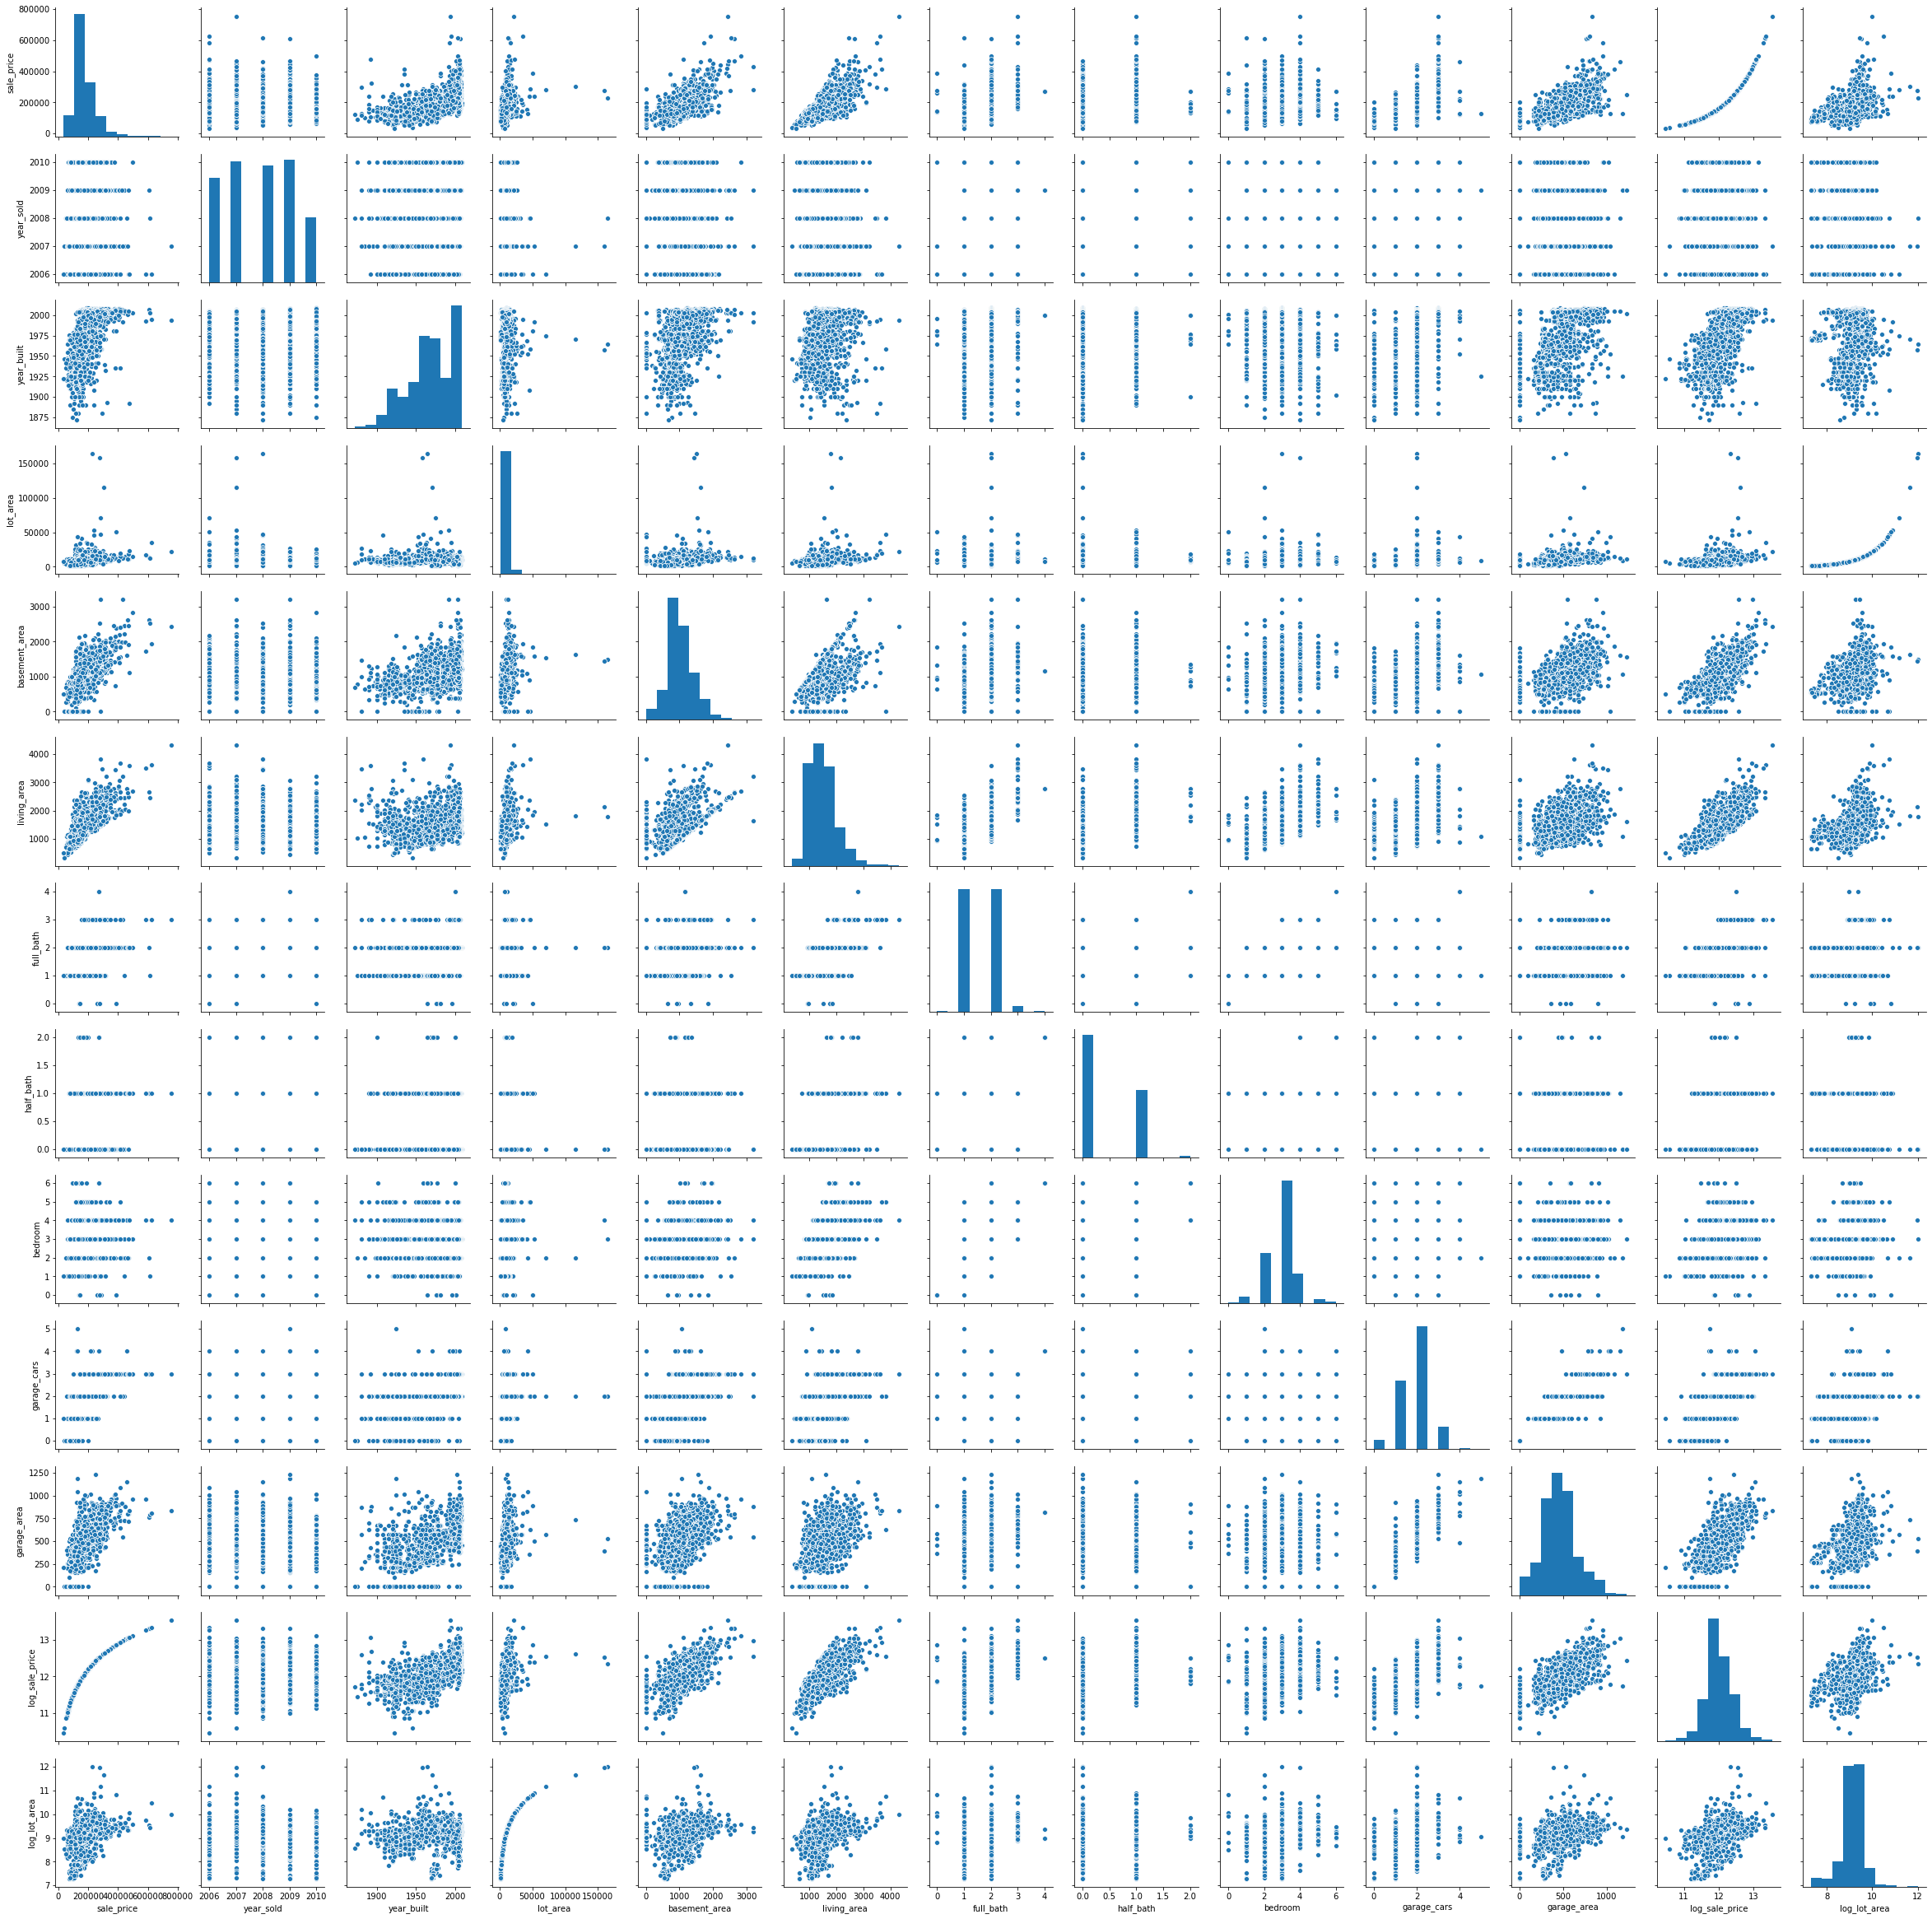

In [3]:
sales['log_sale_price']= np.log(sales['sale_price'])
sales['log_lot_area'] = np.log(sales['lot_area'])
sns.pairplot(sales)
plt.show()
#sns.pairplot(data = sales, hue = quality)

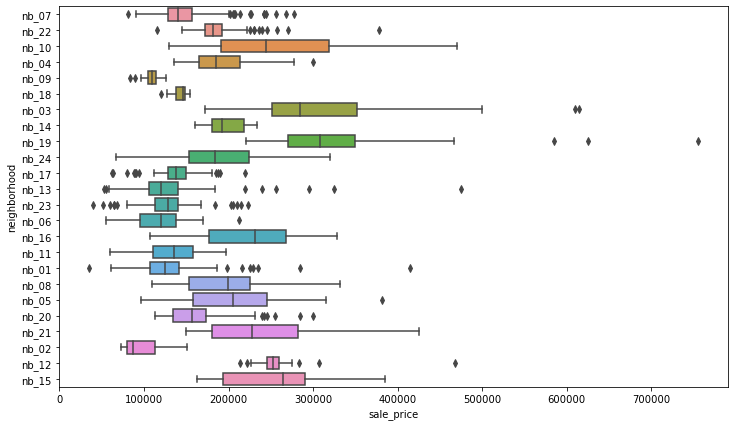

In [4]:

sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

fig, ax = plt.subplots(figsize = [12,7])
sns.boxplot( data = sales, x = 'sale_price', y = 'neighborhood')


sales['log_sale_price']= np.log(sales['sale_price'])
sales['log_lot_area'] = np.log(sales['lot_area'])
sales_test['log_sale_price']= np.log(sales_test['sale_price'])
sales_test['log_lot_area'] = np.log(sales_test['lot_area'])
sales = sales.drop(columns = ['lot_area', 'year_sold'])
sales_test = sales_test.drop(columns = ['lot_area', 'year_sold'])

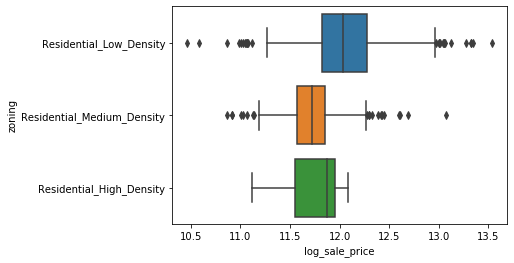

In [5]:
sns.boxplot(data = sales, x = 'log_sale_price', y = 'zoning')

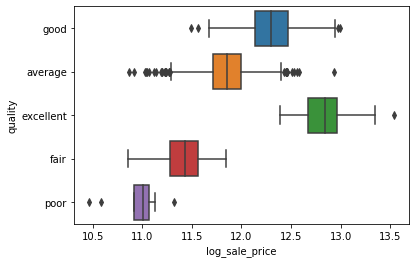

In [6]:
sns.boxplot(data = sales, x = 'log_sale_price', y = 'quality')

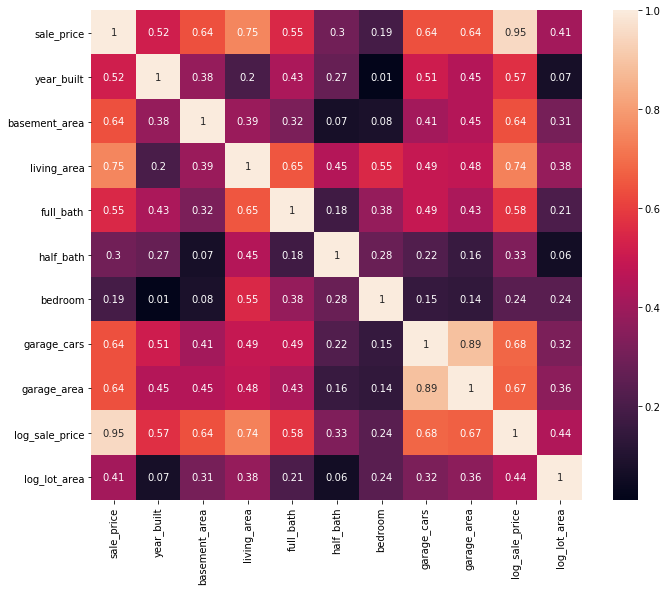

In [7]:
sales['log_sale_price']= np.log(sales['sale_price'])
#sales['log_lot_area'] = np.log(sales['lot_area'])
correlation_matrix = abs(sales.corr().round(2))
# annot = True to print the values inside the square
f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

*Include a discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up.*

*In this section you should also implement and describe any preprocessing / transformations of the features. Hint - you should not be modeling this data without transforming some of the features, e.g. modeling sale price directly is not a good idea.*

 From a preliminary examination of the pairplot and correlation matrix, it seems that the most useful data will be `living_area`, `basement_area`, `garage_area`, and `garage cars`. There seems to be little correlation with `year_sold`, `lot_area` and (surprisingly) `bedroom`. To address this, `year_sold` was dropped as a variable, as it seems to have no correlation at all with `sale_price`. Instead of considering just `lot_area`, the log of this was taken, as this had better correlation with the `sale_price`, (as seen in the correlation matrix.
 
 
 In order to use linear regression, the most basic model, it was required that all the categorical variables be transformed into a suitable form. This was done using the pandas get_dummies function.
 As a development on this, it was decided that the number of neighbourhood categories was too great, so these were grouped into a subset of six different groupings.
 
 This was also done in effect with the variables `half_bath` and `full_bath`, as these are almost categorical variable already 
 
 The box plots also show that we expect quality to be a better indicator than zoning, and nieghbourhood to be a reasonable input.
 
 Additionally, it makes intuitive sense that the price of a house does not scale linearly with the facilities. An attempt was made to account for this by transforming the `sale_price` feature by a logarithm. This is shown to be true by the correlation of the `log_sale_price` to the other variables being higher overall than for the `sale_price`.Some of the preliminary testing done in Section 3 was also done without this tranformation, and achieved worse results, so I believe this change to be justified.
 

In [8]:
def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(y_hat)))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='x', y='y', color="grey", data =  pd.DataFrame(data={'x': [min(y),max(y)], 'y': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

# Section 3

The following models were fit to the data for testing: Linear Regression, Lasso, Ridge Regression, and Regression Trees.
The most simple model to use is indeed the standard linear regression, which produces a rmse of 0.113, and a cross validation score (across 10 folds) of .

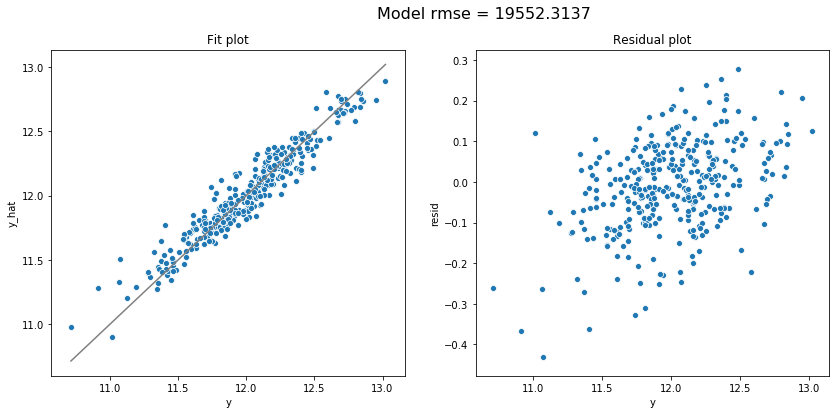

In [9]:
sales = pd.get_dummies(sales, drop_first=True)
sales_test = pd.get_dummies(sales_test, drop_first=True)

lr=LinearRegression()
## 3. Model Fitting and Tuning

X = sales.copy()
X_test = sales_test.copy()
X=X.drop(columns = ['log_sale_price', 'sale_price'])
X_test=X_test.drop(columns = ['log_sale_price', 'sale_price'])


n_fb = 5
n_hb = 3

X_full_bath = pd.get_dummies(pd.cut(X.full_bath, n_fb, labels=['fb_{}'.format(i) for i in range(n_fb)]))
X = pd.concat([X.drop(columns = ['full_bath']),X_full_bath], axis=1)
Xt_full_bath = pd.get_dummies(pd.cut(X_test.full_bath, n_fb, labels=['fb_{}'.format(i) for i in range(n_fb)]))
X_test = pd.concat([X_test.drop(columns = ['full_bath']), Xt_full_bath], axis=1)

X_half_bath = pd.get_dummies(pd.cut(X.half_bath, n_hb, labels=['hb_{}'.format(i) for i in range(n_hb)]))
X = pd.concat([X.drop(columns = ['half_bath']),X_half_bath], axis=1)
Xt_half_bath = pd.get_dummies(pd.cut(X_test.half_bath, n_hb, labels=['hb_{}'.format(i) for i in range(n_hb)]))
X_test = pd.concat([X_test.drop(columns = ['half_bath']), Xt_half_bath], axis=1)

X_tot = pd.concat([X,X_test])
y_tot = pd.concat([sales.log_sale_price,sales_test.log_sale_price])
#cv = np.sqrt(-1 * cross_val_score(l1, X_tot, y_tot, cv=10, scoring="neg_mean_squared_error"))

l = lr.fit(X = X, y = sales.log_sale_price)
LinReg_Model = l
lr_rmse = model_fit(l,X_test, sales_test.log_sale_price,plot=True)


In [10]:
y = sales.log_sale_price
yt = sales_test.log_sale_price
X_comb = pd.concat([X,X_test])

S = StandardScaler().fit(X_comb)
X_sc = pd.DataFrame(S.transform(X))
Xt_sc = pd.DataFrame(S.transform(X_test))

The optimal alpha for ridge regression is: 12.05


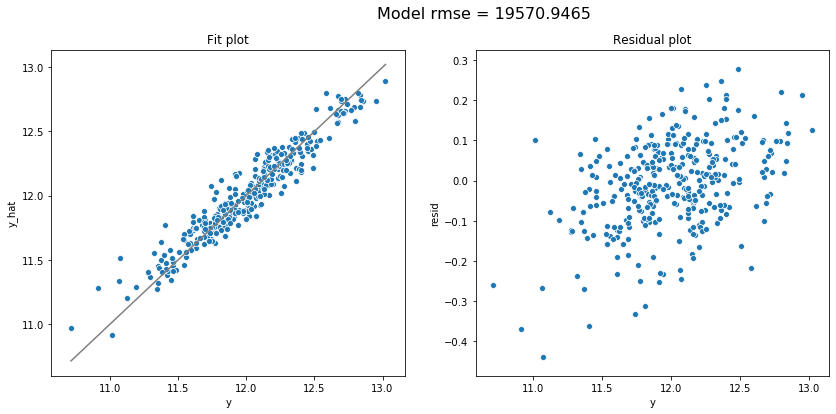

In [11]:
####RIDGE REGRESSION

X_tot_sc = pd.concat([X_sc,Xt_sc])
y_tot = pd.concat([sales.log_sale_price,sales_test.log_sale_price])
sales_tot = pd.concat([sales,sales_test])

r_cv = RidgeCV(
    alphas = np.linspace(0.05,20, num=400),
    scoring = 'neg_mean_squared_error'
).fit(X_sc,y)
print('The optimal alpha for ridge regression is: ' + str(round(r_cv.alpha_,7)))
model_fit(r_cv,Xt_sc,yt, plot=True)

Ridge_Model = r_cv


---

The optimal alpha for ridge regression is: 12.05


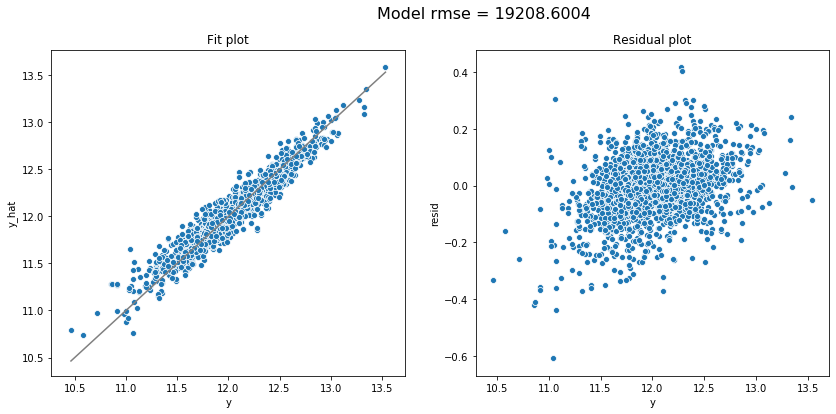

The coefficients of the model are: 
[ 8.91546556e-02  6.25552758e-02  1.46373857e-01 -2.35088912e-02
  2.10180477e-02  2.09388295e-02  4.58513552e-02  2.35897105e-02
  2.37772117e-02  1.49901582e-02 -1.09356673e-02  2.75779498e-02
  9.50724911e-03  3.50989442e-02  4.68279263e-03  1.34374644e-02
  1.64000023e-02  1.07446477e-03  1.82732429e-02  7.81219252e-03
  1.37894119e-02  1.72721834e-03  8.21886784e-03  1.12340955e-02
  1.67240170e-02  4.08947343e-03  8.31975205e-03  2.30486219e-02
  8.52749247e-03  1.74423272e-02  1.31546657e-02  1.64308130e-02
  5.80111575e-03  4.84127555e-02 -1.43598132e-02  4.37004174e-02
 -2.25345659e-02  2.31969838e-02 -2.35164737e-02  4.53077437e-02
 -1.40222714e-02  1.45823380e-03 -7.04784381e-04 -8.91630822e-05
  2.10395808e-03  8.62409534e-04 -6.19666294e-03  7.30999426e-03
 -5.91278188e-03]
The variable columns are: 
year_built
basement_area
living_area
bedroom
garage_cars
garage_area
log_lot_area
ac_Y
zoning_Residential_Low_Density
zoning_Residential_Me

In [19]:
X_tot_sc = pd.concat([X_sc,Xt_sc])
y_tot = pd.concat([sales.log_sale_price,sales_test.log_sale_price])
sales_tot = pd.concat([sales,sales_test])

r_cv_Final = RidgeCV(
    alphas = np.linspace(0.05,20, num=400),
    scoring = 'neg_mean_squared_error'
).fit(X_tot_sc,y_tot)
print('The optimal alpha for ridge regression is: ' + str(round(r_cv.alpha_,7)))
model_fit(r_cv,X_tot_sc,y_tot, plot=True)

Ridge_Model_Final = r_cv_Final
print('The coefficients of the model are: ')
print(Ridge_Model_Final.coef_)
print('The variable columns are: ')
for col in X.columns:
    print(col)

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. Additional code for these models shoulds be included in a supplemental materials notebook or script. What this section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.*

As shown in the appended files, the use of Lasso and Ridge models were not helpful. With Lasso, the optimal Alpha was the lowest it was allowed to be, suggesting that this model is not suitable to the problem. With Ridge regression, the optimal alpha was found to be 12.05, and this model did seem to offer a small improvement to the test rmse of the model. 

The final model that was attempted was a regression trees approach. This has found very minor improvements in the test rmse over linear regression, (roughly 1%) but this could be due to overfitting.
The option to 'bin' all of the numerical variables was enabled with the above code, but some were found to be counter-productive. (For example living area was best left as a numerical variable).
Thus the variables that were binned were as follows: `year_built`, `year_sold`, `garage_area`, `full_bath`, `half_bath`.

After investigation, it was found that the Ridge Regression model was the best, and hence was selected.
All that was required to do to the data therefore was to bin the baths, and then scale the data using the StandardScaler function, fit to the whole data.
After this the function RidgeCV was used to fit the Ridge Regression model to the data. 
This produced a test rmse of $19570, which is the best that has been achieved.

Finally, the entire data set was retrained on the whole data set, as shown below, and then it can be used to evaluate the holdout data in section 5. (With some rescaling to be done once the holdout data is available as well.)

## 4. Discussion


*In this section you should provide a general overview of your final model and its performance. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant. The target audience for this should be someone who is familiar with the basics of real estate and mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

Overall, the test root mean squared error for this model is under $\$20,000$. This gives the user confidence that when this model is used on new data, the predicted answer should have an error of less than $\$20,000$.

The model achieves this level of accuracy through a combination of various data, including the date the house was sold, the living area, the basement area, and the number of bedrooms/baths.

The model was arrived at using Ridge Regression, a modification of simple linear regression that introduces a penalty term in $\mathcal{l}_2$ for the coefficients of the model.
This model is preferred as the penalty reduces the size of coefficients, which should increase the consistency of the performance of the model. 

Analysing the coefficients of the model offers some insight into how it works. The largest coefficient corresponds to the variable `living_area`, as we might expect given the preliminary analysis, this was the most strongly correlated variable. The second highest coefficient corresponded to the variable `year_built`, again this is not surprising, as a strong correlation was observed between this variable and `log_sale_price`.
The smallest coefficient corresponds to one of the `full_bath` bins, indicating that this metric is not at all helpful.

As this model gives a root mean squared error of less than $\$20,000$, this model offers a great amount of practicality for someone looking to buy or sell a house in the covered area. For example if one is considering whether or not to sell one's house, and whether this will be worth it, one can input their house data into the model, and see a reasonably accurate prediction of the sale price. 
As another example, if one is looking to buy a property, and is unsure of what price to offer, this model can give a good example of where to start.

## 5. Model Validation

*We have provided a third csv file called `sales_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `sales_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (350 additional house sales not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of predicting house prices. For example, buyers and sellers are likely to care if the prediction is off by `$20,000` but are less likely to care if it is off by `$500`.*

In [13]:
sales_holdout = pd.read_csv("sales_holdout.csv")
sales_holdout['log_sale_price'] = np.log(sales_holdout.sale_price)
sales_holdout['log_lot_area'] = np.log(sales_holdout.lot_area)
sales_holdout = sales_holdout.drop(columns = ['lot_area', 'year_sold'])


sales_holdout = pd.get_dummies(sales_holdout, drop_first=True)

# Adjust this code as necessary to preprocess the holdout data
X_holdout = sales_holdout.drop(['sale_price','log_sale_price'] ,axis =1)

Xh_full_bath = pd.get_dummies(pd.cut(X_holdout.full_bath, n_fb, labels=['fb_{}'.format(i) for i in range(n_fb)]))
X_holdout = pd.concat([X_holdout.drop(columns = ['full_bath']), Xh_full_bath], axis=1)

Xh_half_bath = pd.get_dummies(pd.cut(X_holdout.half_bath, n_hb, labels=['hb_{}'.format(i) for i in range(n_hb)]))
X_holdout = pd.concat([X_holdout.drop(columns = ['half_bath']), Xh_half_bath], axis=1)

X_comb = pd.concat([X,X_test])
X_comb_full = pd.concat([X_comb,X_holdout])

S_full = StandardScaler().fit(X_comb_full)
X_comb_sc = pd.DataFrame(S_full.transform(X_comb))
X_holdout_sc = pd.DataFrame(S_full.transform(X_holdout))

y_tot = pd.concat([sales.log_sale_price,sales_test.log_sale_price])

r_cv_Final = RidgeCV(
    alphas = np.linspace(0.05,20, num=400),
    scoring = 'neg_mean_squared_error'
).fit(X_comb_sc,y_tot)
#print('The optimal alpha for ridge regression is: ' + str(round(r_cv.alpha_,7)))
#model_fit(r_cv,X_comb_sc,y_tot, plot=True)

Ridge_Model_Final = r_cv_Final
y_holdout = sales_holdout.sale_price

In [14]:
#model_fit(Ridge_Model_Final, X_holdout_sc, np.log(y_holdout), plot=True)

In [15]:
log_y_pred = Ridge_Model_Final.predict(X_holdout_sc)
y_pred = np.exp(log_y_pred)

Final_rmse = np.sqrt( mean_squared_error(y_holdout, y_pred))
log_rmse = np.sqrt( mean_squared_error(log_y_pred,sales_holdout.log_sale_price))
print('The root mean squared error for my model is : {0:.3f}'.format(Final_rmse))
#print(log_rmse)

The root mean squared error for my model is : 18986.426


The usefulness of this model is up for debate. As has been mentioned, the test root mean squared error is between $\$19,000$ and $\$20,000$. This is a large amount of money, but the mean price of a house in the data is close to $\$200,000$, so this represents an error rate of just over 10%.
It is worth mentioning that this model could be improved by an increased amount of data, and that there will always be a certain level of uncertainty. It is also possible that other data about the houses coudl be obtained that is useful, but this seems unlikely. 
It seems that this model is somewhat useful in the industry, but would need to be significantly more accurate, possibly using more advanced techniques, to be uniquely helpful. It does however allow people without specific knowledge of the area and the industry to have some insight into the rough price they should expect for a given house.

---
---

# Appendix

In [16]:
'''Doing Linear Regression without Log Price'''

# sales = pd.read_csv("sales.csv")
# sales_test = pd.read_csv("sales_test.csv")
# #sales['ac_yn']= (sales.ac == 'Y').astype('int')
# sales = pd.get_dummies(sales, drop_first=True)
# sales_test = pd.get_dummies(sales_test, drop_first=True)
# #sns.pairplot(sales)

# sales['log_sale_price']= np.log(sales['sale_price'])
# sales_test['log_sale_price']= np.log(sales_test['sale_price'])
# X = sales.copy()
# X_test = sales_test.copy()
# X=X.drop(columns = ['log_sale_price', 'sale_price'])
# X_test=X_test.drop(columns = ['log_sale_price', 'sale_price'])


# l2 = lr.fit(X = X, y = sales.sale_price)

# sales['sale_price_pred_nl'] = l2.predict(X)

# sales_test['sale_price_pred_nl'] = l2.predict(X_test)



# sales['resid_nl'] = (sales.sale_price-sales.sale_price_pred_nl)

# sales_test['resid_nl'] = (sales_test.sale_price-sales_test.sale_price_pred_nl)

# #print(list(X))
# #print(l1.coef_)
# print(np.sqrt(np.mean((sales_test.resid_nl)**2)))
# #sales_test
# model_fit(l2,X_test, sales_test.sale_price,plot=True)

'Doing Linear Regression without Log Price'

In [17]:
####LASSO REGRESSION####

# alphas = np.linspace(0.01, 1, num=100)

# l_gs = GridSearchCV(
#     Lasso(),
#     param_grid={'alpha': alphas},
#     cv=KFold(5, True, random_state=1234),
#     scoring="neg_mean_squared_error"
# ).fit(X_sc, y)

# print( "best alpha:", l_gs.best_params_['alpha'])
# print( "bestlog_price rmse :", np.sqrt(l_gs.best_score_ * -1))
# print( "validation rmse:", model_fit(l_gs.best_estimator_, Xt_sc, yt) )


In [18]:
####REGRESSION TREES####

# sales = pd.read_csv("sales.csv")
# sales_test = pd.read_csv("sales_test.csv")
# sales = pd.get_dummies(sales, drop_first=True)
# sales_test = pd.get_dummies(sales_test, drop_first=True)
# sales['log_sale_price']= np.log(sales['sale_price'])
# sales_test['log_sale_price']= np.log(sales_test['sale_price'])
# X =sales.drop(columns = ['log_sale_price', 'sale_price'])
# y = sales.log_sale_price
# Xt = sales_test.drop(columns = ['log_sale_price','sale_price'])
# yt = sales_test.log_sale_price
# n_living = 100
# n_basement = 1
# n_yb = 10
# n_ys = 5
# n_lot = 50
# n_ga = 5
# n_fb = 5
# n_hb = 3
# n_gc = 6
# n_bedroom = 6

# # X_living = pd.get_dummies(pd.cut(X.living_area,n_living, labels=['living_{}'.format(i) for i in range(n_living)]))#labels=[''.format(i+12) for i in range(10)]))
# # X = pd.concat([X.drop(columns = ['living_area']),X_living], axis=1)
# # Xt_living = pd.get_dummies(pd.cut(Xt.living_area,n_living, labels=['living_{}'.format(i) for i in range(n_living)]))
# # Xt = pd.concat([Xt.drop(columns = ['living_area']),Xt_living], axis=1)

# # X_basement = pd.get_dummies(pd.cut(X.basement_area,n_basement, labels=['basement_{}'.format(i) for i in range(n_basement)]))#labels=[''.format(i+12) for i in range(10)]))
# # X = pd.concat([X.drop(columns = ['basement_area']),X_basement], axis=1)
# # Xt_basement = pd.get_dummies(pd.cut(Xt.basement_area,n_basement, labels=['basement_{}'.format(i) for i in range(n_basement)]))
# # Xt = pd.concat([Xt.drop(columns = ['basement_area']),Xt_basement], axis=1)

# X_year_built = pd.get_dummies(pd.cut(X.year_built, n_yb, labels=['yb_{}'.format(i) for i in range(n_yb)]))
# X = pd.concat([X.drop(columns = ['year_built']),X_year_built], axis=1)
# Xt_year_built = pd.get_dummies(pd.cut(Xt.year_built, n_yb, labels=['yb_{}'.format(i) for i in range(n_yb)]))
# Xt = pd.concat([Xt.drop(columns = ['year_built']), Xt_year_built], axis=1)

# X_year_sold = pd.get_dummies(pd.cut(X.year_sold, n_ys, labels=['ys_{}'.format(i) for i in range(n_ys)]))
# X = pd.concat([X.drop(columns = ['year_sold']),X_year_sold], axis=1)
# Xt_year_sold = pd.get_dummies(pd.cut(Xt.year_sold, n_ys, labels=['ys_{}'.format(i) for i in range(n_ys)]))
# Xt = pd.concat([Xt.drop(columns = ['year_sold']), Xt_year_sold], axis=1)

# # X_lot = pd.get_dummies(pd.cut(X.lot_area,n_lot, labels=['lot_{}'.format(i) for i in range(n_lot)]))
# # X = pd.concat([X.drop(columns = ['lot_area']), X_lot], axis=1)
# # Xt_lot = pd.get_dummies(pd.cut(Xt.lot_area,n_lot, labels=['lot_{}'.format(i) for i in range(n_lot)]))
# # Xt = pd.concat([Xt.drop(columns = ['lot_area']), Xt_lot], axis=1)

# X_garage_area = pd.get_dummies(pd.cut(X.garage_area, n_ga, labels=['ga_{}'.format(i) for i in range(n_ga)]))
# X = pd.concat([X.drop(columns = ['garage_area']), X_garage_area], axis=1)
# Xt_garage_area = pd.get_dummies(pd.cut(Xt.garage_area, n_ga, labels=['ga_{}'.format(i) for i in range(n_ga)]))
# Xt = pd.concat([Xt.drop(columns = ['garage_area']), Xt_garage_area], axis=1)

# X_full_bath = pd.get_dummies(pd.cut(X.full_bath, n_fb, labels=['fb_{}'.format(i) for i in range(n_fb)]))
# X = pd.concat([X.drop(columns = ['full_bath']),X_full_bath], axis=1)
# Xt_full_bath = pd.get_dummies(pd.cut(Xt.full_bath, n_fb, labels=['fb_{}'.format(i) for i in range(n_fb)]))
# Xt = pd.concat([Xt.drop(columns = ['full_bath']), Xt_full_bath], axis=1)

# X_half_bath = pd.get_dummies(pd.cut(X.half_bath, n_hb, labels=['hb_{}'.format(i) for i in range(n_hb)]))
# X = pd.concat([X.drop(columns = ['half_bath']),X_half_bath], axis=1)
# Xt_half_bath = pd.get_dummies(pd.cut(Xt.half_bath, n_hb, labels=['hb_{}'.format(i) for i in range(n_hb)]))
# Xt = pd.concat([Xt.drop(columns = ['half_bath']), Xt_half_bath], axis=1)

# # X_garage_cars = pd.get_dummies(pd.cut(X.garage_cars, n_gc, labels=['gc_{}'.format(i) for i in range(n_gc)]))
# # X = pd.concat([X.drop(columns = ['garage_cars']),X_garage_cars], axis=1)
# # Xt_garage_cars = pd.get_dummies(pd.cut(Xt.garage_cars, n_gc, labels=['gc_{}'.format(i) for i in range(n_gc)]))
# # Xt = pd.concat([Xt.drop(columns = ['garage_cars']), Xt_garage_cars], axis=1)

# #X_bedroom = pd.get_dummies(pd.cut(X.bedroom, n_bedroom, labels = ['bedroom_{}'.format(i) for i in range(n_bedroom)]))
# #X = pd.concat([X.drop(columns = ['bedroom']), X_bedroom], axis=1)
# #Xt_bedroom = pd.get_dummies(pd.cut(Xt.bedroom, n_bedroom, labels = ['bedroom_{}'.format(i) for i in range(n_bedroom)]))
# #Xt = pd.concat([Xt.drop(columns = ['bedroom']), Xt_bedroom], axis=1)


# Reg_Tree_Model = LinearRegression(fit_intercept=False).fit(X,y)
# sales["pred_log_sale_price"] = Reg_Tree_Model.predict(X)
# sales_test["pred_log_sale_price"] = Reg_Tree_Model.predict(Xt)
# #model_fit(Reg_Tree_Model, X, y, plot=True)
# model_fit(Reg_Tree_Model, Xt, yt, plot=True)
# np.sqrt(mean_squared_error(sales_test.log_sale_price,sales_test.pred_log_sale_price))

# cv = np.sqrt(-1 * cross_val_score(Reg_Tree_Model, X_tot, y_tot, cv=5, scoring="neg_mean_squared_error"))
# print('The cross validation rmse is : {}'.format(np.mean(cv)))
# # Cross Validation

# m = make_pipeline(
#     PolynomialFeatures(degree=1),
#     LinearRegression(fit_intercept=False)
# )

# cv=np.sqrt(-cross_val_score(m, X, y, cv=5, scoring="neg_mean_squared_error"))
# print(cv)
# print(np.mean(cv))
